# Spectrograms

The aim of this notebook is to pick the best parameters for the spectrograms. Main challange is to find such threshhold in Voice Activity Detector (VAD) that will not cut relevant parts of the signal, but will cut the silence.

In [49]:
import torch
import torchaudio
import librosa
import noisereduce as nr
import matplotlib.pyplot as plt

from dataset_prep import AudioProcessing

In [ ]:
# Those 2 functions are taken from the torchaudio documentation
# source: https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)
    
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

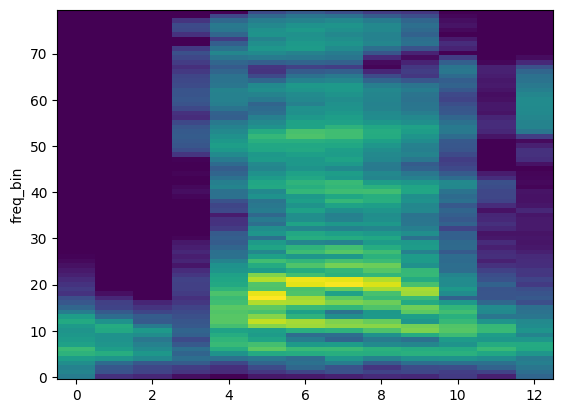

In [47]:
pipeline = AudioProcessing()
waveform, sample_rate = torchaudio.load("../data-audio/train/bed/0a7c2a8d_nohash_0.wav", normalize=True)
features = pipeline(waveform, sample_rate)
plot_spectrogram(features[0])

In [54]:
features.shape

torch.Size([1, 80, 13])

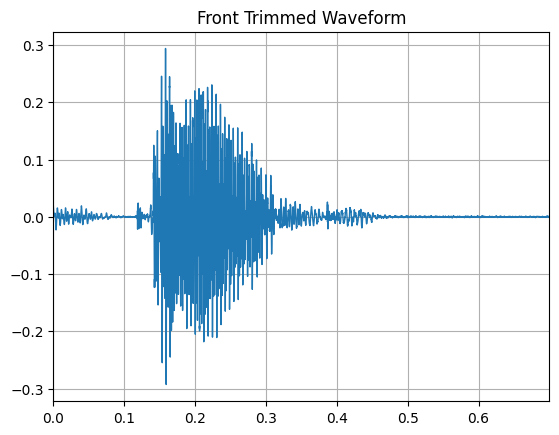

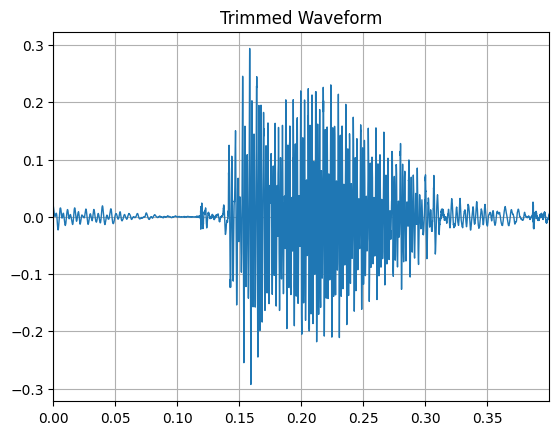

In [77]:
trigger_level = 0.001
trigger_time = 0.1
front_trimmed = torchaudio.functional.vad(waveform, sample_rate, trigger_level=trigger_level, trigger_time=trigger_time)
plot_waveform(front_trimmed, sample_rate, title="Front Trimmed Waveform")
flipped_waveform = torch.flip(front_trimmed, [1])
trimmed_waveform = torchaudio.functional.vad(flipped_waveform, sample_rate, trigger_level=trigger_level, trigger_time=trigger_time)
trimmed_waveform = torch.flip(trimmed_waveform, [1])
plot_waveform(trimmed_waveform, sample_rate, title="Trimmed Waveform")

In [ ]:
torchaudio.save("../audio/vad.wav", trimmed_waveform, sample_rate)
torchaudio.save("../audio/vad_front.wav", front_trimmed, sample_rate)

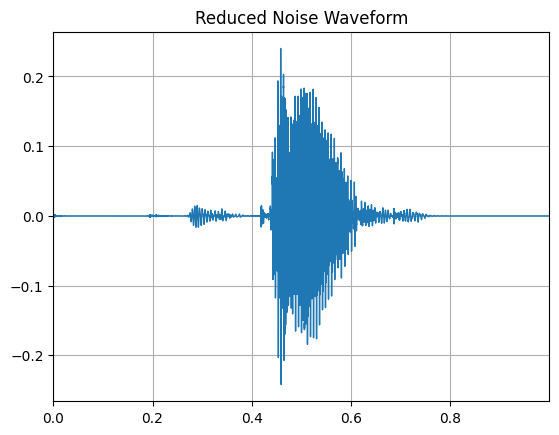

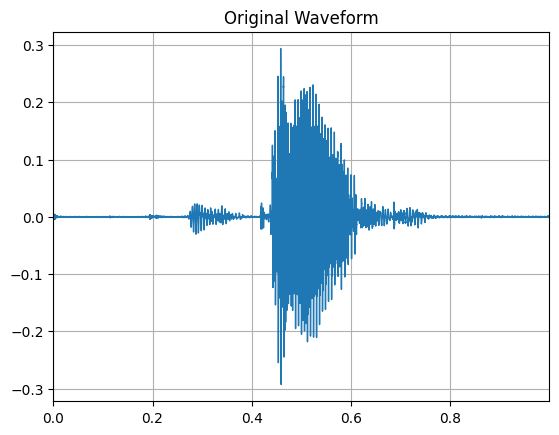

In [12]:
audio, sr = torchaudio.load("../data-audio/train/bed/0a7c2a8d_nohash_0.wav")
noise_profile = audio[:int(sr * 0.5)]
reduced_noise = nr.reduce_noise(y=audio, sr=sr, y_noise=noise_profile)
reduced_noise = torch.from_numpy(reduced_noise).float()
plot_waveform(reduced_noise, sr, title="Reduced Noise Waveform")
plot_waveform(audio, sr, title="Original Waveform")

torch.Size([1, 80, 13])


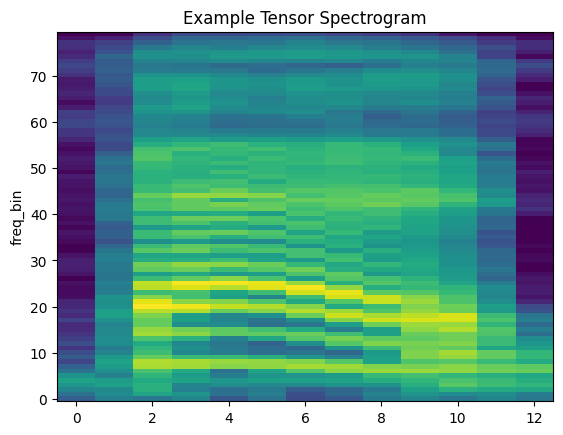

In [56]:
# loading example .pt file with tensor data
example_tensor = torch.load("../data-mel-spectrograms/train/bed/00f0204f_nohash_0.pt")
print(example_tensor.shape)
plot_spectrogram(example_tensor[0], title="Example Tensor Spectrogram")

torch.Size([1, 80, 12])


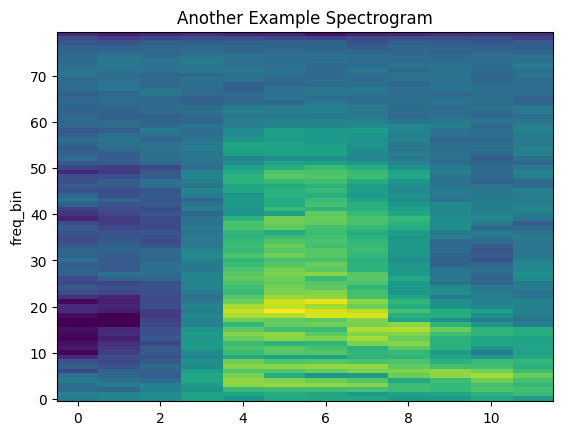

In [59]:
another_example, sr = torchaudio.load("../data-audio/train/bed/1bb574f9_nohash_0.wav")
result = pipeline(another_example, sr)
print(result.shape)
plot_spectrogram(result[0], title="Another Example Spectrogram")

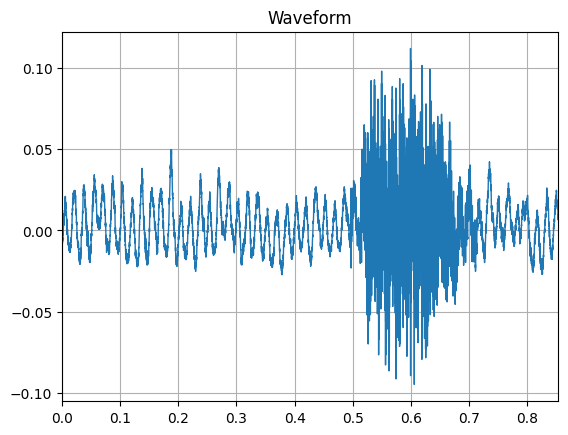

In [81]:
problematic_example, sr = torchaudio.load("../data-audio/train/bed/014f9f65_nohash_0.wav")
plot_waveform(problematic_example, sr)

tensor([], size=(1, 0))


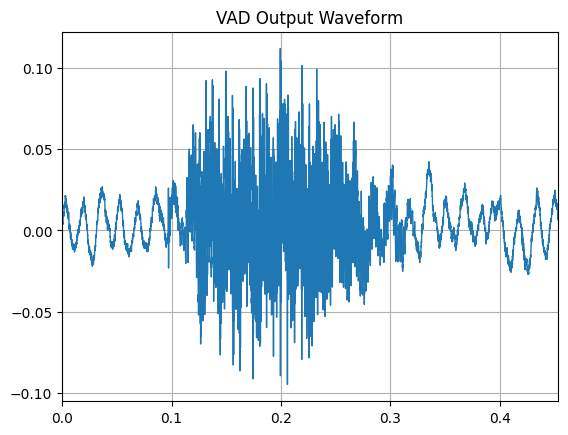

In [90]:
vad_output = torchaudio.functional.vad(problematic_example, sr, trigger_level=trigger_level, trigger_time=trigger_time)
plot_waveform(vad_output, sr, title="VAD Output Waveform")
backward_trimmed = torch.flip(vad_output, [1])
backward_trimmed = torchaudio.functional.vad(backward_trimmed, sr, trigger_level=0.000001, trigger_time=1)
backward_trimmed = torch.flip(backward_trimmed, [1])
print(backward_trimmed)